In [ ]:
!pip install pandas numpy scipy matplotlib backtrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 6.4 MB/s eta 0:00:00


In [ ]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=80737df445e306fd009e79d857fa4c1ee0be69e1fe76429b2fb4948f76f4024e
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from filterpy.kalman import KalmanFilter
import backtrader as bt

In [ ]:
# Load data
data = pd.read_csv('btcusdt_1h.csv', parse_dates=['datetime'])
data.set_index('datetime', inplace=True)

In [ ]:
data.head()

,open,high,low,close,volume
datetime,,,,,
2018-01-01 05:30:00,13715.65,13715.65,13400.01,13529.01,443.356199
2018-01-01 06:30:00,13528.99,13595.89,13155.38,13203.06,383.697006
2018-01-01 07:30:00,13203.00,13418.43,13200.00,13330.18,429.064572
2018-01-01 08:30:00,13330.26,13611.27,13290.00,13410.03,420.087030
2018-01-01 09:30:00,13434.98,13623.29,13322.15,13601.01,340.807329


In [ ]:
def rolling_average(data, window):
    df_rolling = data.copy()
    df_rolling['close'] = df_rolling['close'].rolling(window=window).mean()
    return df_rolling.dropna()

In [ ]:
def savgol_filtering(data, window, polyorder):
    df_savgol = data.copy()
    df_savgol['close'] = savgol_filter(df_savgol['close'], window_length=window, polyorder=polyorder)
    return df_savgol.dropna()

In [ ]:
def kalman_filter(data):
    kf = KalmanFilter(dim_x=2, dim_z=1)
    kf.x = np.array([data['close'].values[0], 0])
    kf.F = np.array([[1, 1], [0, 1]])
    kf.H = np.array([[1, 0]])
    kf.P *= 1000.
    kf.R = 5
    kf.Q = np.array([[0.1, 0], [0, 0.1]])

    filtered_data = []
    for z in data['close'].values:
        kf.predict()
        kf.update(z)
        filtered_data.append(kf.x[0])

    df_kalman = data.copy()
    df_kalman['close'] = filtered_data
    return df_kalman.dropna()

In [ ]:
def heiken_ashi(data):
    ha_data = data.copy()
    ha_data['close'] = (data['open'] + data['high'] + data['low'] + data['close']) / 4
    ha_data['open'] = (data['open'].shift(1) + data['close'].shift(1)) / 2
    ha_data.iloc[0, ha_data.columns.get_loc('open')] = (data['open'][0] + data['close'][0]) / 2
    ha_data['high'] = data[['open', 'high', 'close']].max(axis=1)
    ha_data['low'] = data[['open', 'low', 'close']].min(axis=1)
    return ha_data.dropna()

In [ ]:
data_rolling = rolling_average(data, window=10)
data_savgol = savgol_filtering(data, window=11, polyorder=2)
data_kalman = kalman_filter(data)
data_heiken = heiken_ashi(data)

In [ ]:
#choosing MACD as trading strategy
class MACDStrategy(bt.Strategy):
    params = (
        ('fast', 12),
        ('slow', 26),
        ('signal', 9),
    )

    def __init__(self):
        self.macd = bt.indicators.MACDHisto(
            self.data.close,
            period_me1=self.params.fast,
            period_me2=self.params.slow,
            period_signal=self.params.signal
        )

    def next(self):
        if self.macd.histo[0] > 0 and self.macd.histo[-1] <= 0:  # Buy signal
            self.buy()
        elif self.macd.histo[0] < 0 and self.macd.histo[-1] >= 0:  # Sell signal
            self.sell()

In [ ]:
def backtest(data):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MACDStrategy)
    data_feed = bt.feeds.PandasData(dataname=data)
    cerebro.adddata(data_feed)
    cerebro.broker.setcash(10000)
    cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
    cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='annualreturn')
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    result = cerebro.run()
    return cerebro, result

In [ ]:
def calculate_metrics(result):
    strat = result[0]
    sharpe = strat.analyzers.sharpe.get_analysis().get('sharperatio', None)
    drawdown = strat.analyzers.drawdown.get_analysis().max.drawdown
    total_return = strat.analyzers.returns.get_analysis().get('rnorm100', None)
    annualized_return = strat.analyzers.annualreturn.get_analysis().get('rnorm100', None)
    pnl = strat.broker.getvalue() - 10000  # Assuming initial capital is 10000
    return {
        'PnL': pnl,
        'Sharpe Ratio': sharpe,
        'Max Drawdown': drawdown,
        'Total Return': total_return,
        'Annualized Return': annualized_return,
    }


In [ ]:
# Backtest on original data
cerebro_original, result_original = backtest(data)

In [ ]:
# Backtest on denoised data
cerebro_rolling, result_rolling = backtest(data_rolling)
cerebro_savgol, result_savgol = backtest(data_savgol)
cerebro_kalman, result_kalman = backtest(data_kalman)
cerebro_heiken, result_heiken = backtest(data_heiken)

In [ ]:
metrics_original = calculate_metrics(result_original)
metrics_rolling = calculate_metrics(result_rolling)
metrics_savgol = calculate_metrics(result_savgol)
metrics_kalman = calculate_metrics(result_kalman)
metrics_heiken = calculate_metrics(result_heiken)

print("Original Data Metrics:", metrics_original)
print("Rolling Average Data Metrics:", metrics_rolling)
print("Savitzky-Golay Filter Data Metrics:", metrics_savgol)
print("Kalman Filter Data Metrics:", metrics_kalman)
print("Heiken Ashi Data Metrics:", metrics_heiken)
# Calculated and compared performance metrics

Original Data Metrics: {'PnL': 4206.179999999942, 'Sharpe Ratio': 0.340907102935238, 'Max Drawdown': 93.2177913285778, 'Total Return': 6.190516158865918, 'Annualized Return': None}
Rolling Average Data Metrics: {'PnL': 9822.890000000058, 'Sharpe Ratio': 0.4247577538373428, 'Max Drawdown': 94.77626992920385, 'Total Return': 12.418854560248436, 'Annualized Return': None}
Savitzky-Golay Filter Data Metrics: {'PnL': 219617.79000000015, 'Sharpe Ratio': 0.9238908572468212, 'Max Drawdown': 10.023544671333193, 'Total Return': 70.9385636564767, 'Annualized Return': None}
Kalman Filter Data Metrics: {'PnL': 26856.609999999935, 'Sharpe Ratio': 0.6992341660994977, 'Max Drawdown': 67.21507276527123, 'Total Return': 25.002623927389184, 'Annualized Return': None}
Heiken Ashi Data Metrics: {'PnL': 107072.37999999998, 'Sharpe Ratio': 0.9927571502142317, 'Max Drawdown': 16.13478224753651, 'Total Return': 52.3318012895914, 'Annualized Return': None}


As evident from the obtained values, Savitzky-Golay Filter Data Metrics seems to be the most effective strategy.

Heiken Ashi is also worth mentioning as it also has exceptional returns.

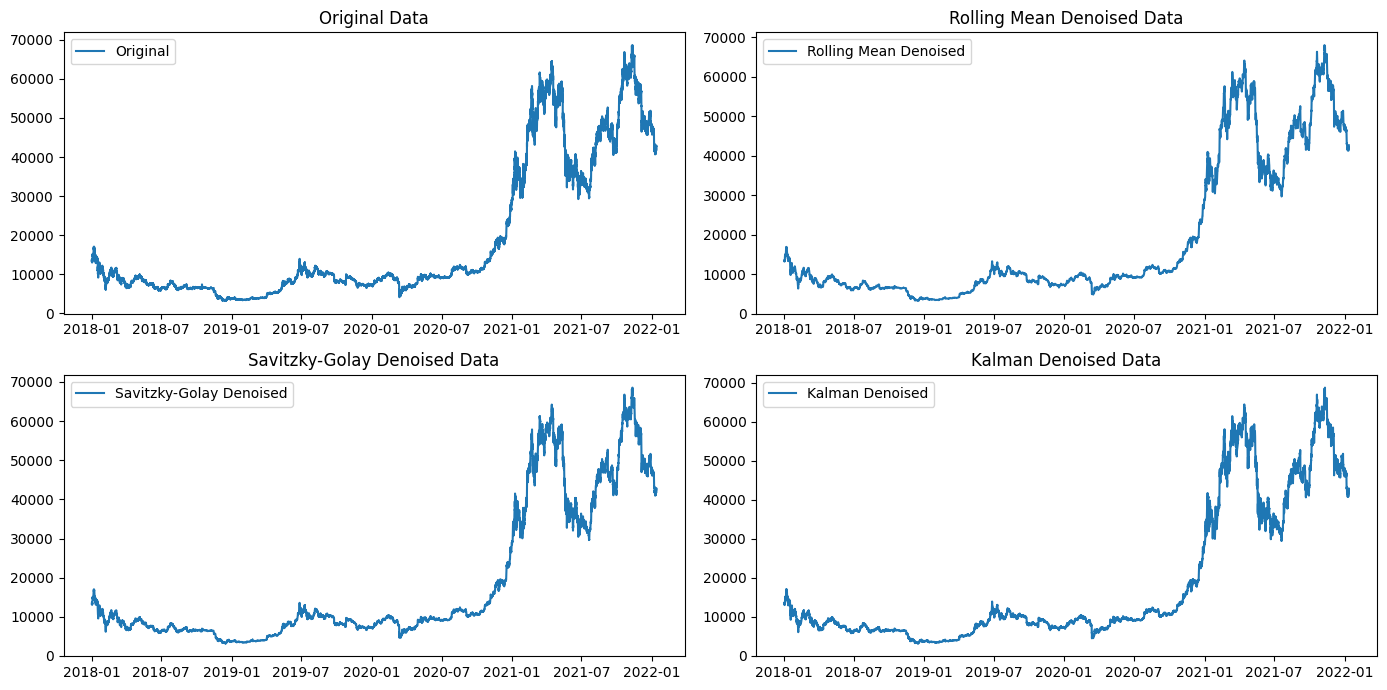

In [ ]:

# Plot results
plt.figure(figsize=(14, 7))

plt.subplot(2, 2, 1)
plt.plot(data['close'], label='Original')
plt.title('Original Data')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(data_rolling['close'], label='Rolling Mean Denoised')
plt.title('Rolling Mean Denoised Data')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(data_savgol['close'], label='Savitzky-Golay Denoised')
plt.title('Savitzky-Golay Denoised Data')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(data_kalman['close'], label='Kalman Denoised')
plt.title('Kalman Denoised Data')
plt.legend()

plt.tight_layout()
plt.show()